# Performance of different RL models on the CartPole task

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.gridspec import GridSpec
import seaborn as sns
import tqdm
import time
from pathlib import Path
import puffbird as pb
import pandas as pd

from stable_baselines3.common.evaluation import evaluate_policy

from rl_add.utils import get_model, get_eval_env


datapath = Path('data')
datapath.mkdir(parents=True, exist_ok=True)

In [2]:
# hyperparameters
gravity_factors = np.arange(1, 10)
learn_gravity_factor = 1
n_eval_episodes = 100
num_experiments = 10
rerun = False  # rerunning and saving trained models

models = ['PPO', 'DQN', 'A2C']

In [3]:
optimal_timesteps = {
    'DQN': 5e4, 
    'A2C': 5e5, 
    'PPO': 1e5
}

In [4]:
if rerun or not (datapath / "eval_rewards.pkl").exists():
    results = {}
    for idx in range(num_experiments):
        results[idx] = {}
        for mtype in models:
            print(mtype)
            print('learning')
            model, mon = get_model(mtype)
            now = time.time()
            model.learn(total_timesteps=optimal_timesteps[mtype])
            tlearn = time.time() - now
            rewards = [m() for m in mon.get_attr('get_episode_rewards')]
            mrews, srews = [], []
            for gravity_factor in tqdm.tqdm(gravity_factors):
                eval_env = get_eval_env(mtype, gravity_factor)
                mean_reward, std_reward = evaluate_policy(
                    model, eval_env, n_eval_episodes=n_eval_episodes,
                    deterministic=True
                )
                mrews.append(mean_reward)
                srews.append(std_reward)
            results[idx][mtype] = {
                'rewards': rewards, 
                'model': model, 
                'tlearn': tlearn, 
                'mean_rewards': np.array(mrews), 
                'std_rewards': np.array(srews)
            }
            
    df = pd.DataFrame(results).stack()
    df.index.names = ['model_name', 'exp_idx']
    df = df.apply(pd.Series, dtype=object)

    total_times = df['tlearn'].reset_index()
    learn_rewards = pb.puffy_to_long(df[['rewards', 'tlearn']])
    learn_rewards['time'] = learn_rewards['tlearn'] / learn_rewards['rewards_level1']
    learn_rewards['evaluation'] = learn_rewards['rewards_level1']
    learn_rewards['units'] = (
        learn_rewards['rewards_level0'].astype(str)
        + learn_rewards['exp_idx'].astype(str)
    ).astype('category').cat.codes
    eval_rewards = pb.puffy_to_long(df[['mean_rewards', 'std_rewards']], factor_idx={'mean_rewards': 0, 'std_rewards': 0})
    eval_rewards['gravity_factor'] = np.array(gravity_factors)[eval_rewards['factor_idx'].to_numpy()]
    eval_rewards['units'] = eval_rewards['exp_idx']
    
    total_times.to_pickle(datapath / 'total_times.pkl')
    learn_rewards.to_pickle(datapath / 'learn_rewards.pkl')
    eval_rewards.to_pickle(datapath / 'eval_rewards.pkl')
    
    modelpath = datapath / 'models'
    modelpath.mkdir(exist_ok=True, parents=True)
    for name, trained_model in df['model'].items():
        name = '-'.join([str(n) for n in name])
        trained_model.save(modelpath / name)
        
else:
    total_times = pd.read_pickle(datapath / 'total_times.pkl')
    learn_rewards = pd.read_pickle(datapath / 'learn_rewards.pkl')
    eval_rewards = pd.read_pickle(datapath / 'eval_rewards.pkl')

In [5]:
eval_rewards['gravity'] = eval_rewards['gravity_factor'] * 9.8

/Users/gucky92/opt/anaconda3/envs/scientific/lib/python3.10/site-packages/seaborn/categorical.py:1680: UserWarning: You passed a edgecolor/edgecolors ([(0.0, 0.0, 0.0), (0.0, 0.0, 0.0), (0.0, 0.0, 0.0)]) for an unfilled marker ('_').  Matplotlib is ignoring the edgecolor in favor of the facecolor.  This behavior may change in the future.
  ax.scatter(x, y,


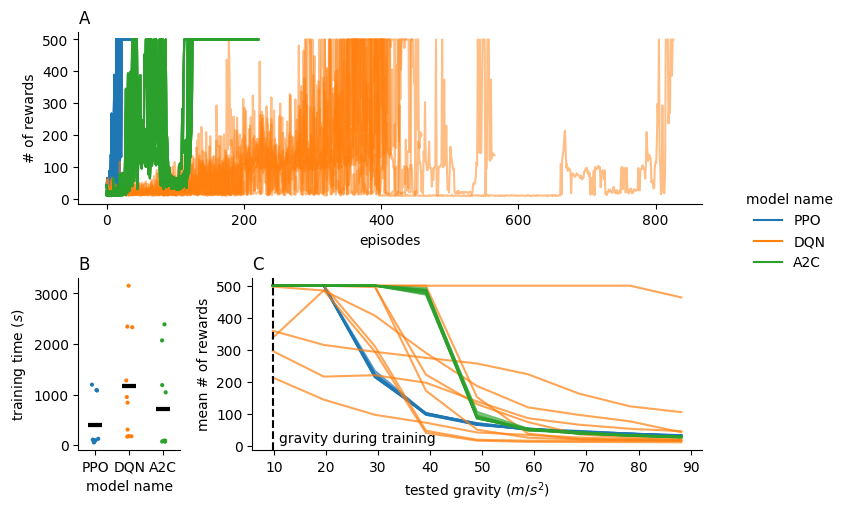

In [6]:
fig = plt.figure(constrained_layout=True, figsize=(7, 5))
gs = GridSpec(2, 4, figure=fig)
ax1 = fig.add_subplot(gs[0, :])
ax2 = fig.add_subplot(gs[1, 0])
ax3 = fig.add_subplot(gs[1, 1:])

ax1 = sns.lineplot(
    data=learn_rewards, 
    y='rewards',
    x='evaluation', 
    hue='model_name', 
    estimator=None, 
    units='units', 
    alpha=0.5, 
    ax=ax1, 
)
ax1.set_xlabel('episodes')
ax1.set_ylabel('# of rewards')
ax1.set_title('A', loc='left')

sns.stripplot(
    data=total_times, y='tlearn', x='model_name', 
    hue='model_name', legend=False,
    ax=ax2, size=3
)
sns.pointplot(
    data=total_times, y='tlearn', x='model_name', 
    join=False, errorbar=None, color='black', 
    ax=ax2, markers='_', scale=1.5
)
ax2.set_title('B', loc='left')
ax2.set_ylabel('training time ($s$)')
ax2.set_xlabel('model name')

sns.lineplot(
    data=eval_rewards, 
    hue='model_name', 
    y='mean_rewards', 
    x='gravity', 
    estimator=None, 
    units='units', 
    alpha=0.7, 
    ax=ax3, 
    legend=False
)
ax3.axvline(9.8, color='black', linestyle='--')
ax3.annotate('gravity during training', (11, 10), (11, 10), )
ax3.set_title('C', loc='left')
ax3.set_ylabel('mean # of rewards')
ax3.set_xlabel('tested gravity ($m/s^2$)')

handles, labels = ax1.get_legend_handles_labels()
ax1.get_legend().remove()
fig.legend(
    handles, labels, title='model name', 
    loc='upper right', ncol=1, bbox_to_anchor=(1.2, 0.65), 
    frameon=False
)
sns.despine()
fig.savefig('figure.pdf', bbox_inches='tight')
fig.savefig('figure.png', bbox_inches='tight')
